# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w09-02-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W0902',
    '2023W0901',
    '2023W0801',
    #'2023W0704',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-08 03:36:57.322157: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 03:36:59.477962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-08 03:36:59.479192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-08 03:36:59.480653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-03-08 03:37:02,444[INFO][139758666794816-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379
2023-03-08 03:37:03,820[INFO][139758666794816-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-08 03:37:03,822[INFO][139758666794816-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-03-08 03:37:05,379	WARNING read_api.py:256 -- The number of blocks in this dataset (15) limits its parallelism to 15 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0   196890
1    1.0   143910

## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0         0.0      1.000000         0.0          0.0         0.0         0.0   
1         0.0      0.995055         0.0          0.0         0.0         0.0   
2         0.0      1.000000         0.0          0.0         0.0         0.0   
3         0.0      1.000000         0.0          0.0         0.0         0.0   
4         1.0      1.000000         0.0          0.0         0.0         0.0   
...       ...           ...         ...          ...         ...         ...   
340795    0.0      0.000000         0.0          0.0         0.0         0.0   
340796    0.0      0.964028         0.0          0.0         0.0         0.0   
340797    0.0      0.000000         0.0          0.0         0.0         0.0   
340798    0.0      0.000000         0.0          0.0         0.0         0.0   
340799    0.0      0.000000         1.0          1.0         1.0         0.0   

        bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                    1.0             1.0             1.0          1.0   
1                    0.0             0.0             0.0          0.0   
2                    1.0             1.0             1.0          1.0   
3                    1.0             1.0             1.0          1.0   
4                    1.0             1.0             1.0          1.0   
...                  ...             ...             ...          ...   
340795               0.0             0.0             1.0          0.0   
340796               0.0             0.0             0.0          0.0   
340797               0.0             0.0             0.0          0.0   
340798               0.0             0.0             1.0          0.0   
340799               1.0             1.0             1.0          1.0   

        bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0                1.0     0.000000          1.0          1.0              1.0   
1                0.0     0.000000          0.0          0.0              0.0   
2                1.0     1.000000          1.0          1.0              1.0   
3                1.0     1.000000          1.0          1.0              1.0   
4                1.0     1.000000          1.0          1.0              1.0   
...              ...          ...          ...          ...              ...   
340795           0.0     0.000000          0.0          0.0              1.0   
340796           0.0     0.000000          0.0          0.0              0.0   
340797           0.0     0.000000          0.0          0.0              0.0   
340798           0.0     0.000000          0.0          0.0              1.0   
340799           1.0     0.999998          1.0          1.0              1.0   

        bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                    1.0              0.0         1.000000        1.000000   
1                    0.0              0.0         0.000000        0.000000   
2                    1.0              0.0         1.000000        0.999909   
3                    1.0              0.0         1.000000        1.000000   
4                    1.0              0.0         0.986752        1.000000   
...                  ...              ...              ...             ...   
340795               1.0              1.0         0.000000        0.000000   
340796               0.0              0.0         0.000000        0.000000   
340797               0.0              0.0         0.000000        0.000000   
340798               1.0              1.0         0.000000        0.000000   
340799               1.0              1.0         1.000000        1.000000   

        bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0         1.000000            0.0               1.0            0.0   
1         0.000000            0.0               0.0            0.0   
2         1.000000            0.0               1.0           

In [8]:
L_predict[[LABEL, *features]].describe()

label   ack_flag_cnt     active_max    active_mean  \
count  340800.000000  340800.000000  340800.000000  340800.000000   
mean        0.422271       0.922322       0.112729       0.112729   
std         0.493922       0.215154       0.316262       0.316262   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.964028       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          active_min     active_std  bwd_blk_rate_avg  bwd_byts_b_avg  \
count  340800.000000  340800.000000     340800.000000   340800.000000   
mean        0.112729       0.082472          0.523148        0.525566   
std         0.316262       0.275082          0.501879        0.499347   
min         0.000000       0.000000         -1.000000        0.000000   
25%         0.000000       0.000000          0.000000        0.000000   
50%         0.000000       0.000000          1.000000        1.000000   
75%         0.000000       0.000000          1.000000        1.000000   
max         1.000000       1.000000          1.000000        1.000000   

       bwd_header_len    bwd_iat_max   bwd_iat_mean    bwd_iat_min  \
count   340800.000000  340800.000000  340800.000000  340800.000000   
mean         0.710854       0.662993       0.661150       0.656967   
std          0.453367       0.472694       0.475268       0.478682   
min          0.000000      -1.000000      -1.000000      -1.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          1.000000       1.000000       1.000000       1.000000   
75%          1.000000       1.000000       1.000000       1.000000   
max          1.000000       1.000000       1.000000       1.000000   

         bwd_iat_std    bwd_iat_tot  bwd_pkt_len_max  bwd_pkt_len_mean  \
count  340800.000000  340800.000000    340800.000000     340800.000000   
mean        0.655141       0.661150         0.685707          0.685673   
std         0.475323       0.475268         0.464208          0.464212   
min         0.000000      -1.000000         0.000000          0.000000   
25%         0.000000       0.000000         0.000000          0.000000   
50%         1.000000       1.000000         1.000000          1.000000   
75%         1.000000       1.000000         1.000000          1.000000   
max         1.000000       1.000000         1.000000          1.000000   

       bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg     bwd_pkts_s  \
count    340800.000000    340800.000000   340800.000000  340800.000000   
mean          0.103246         0.629681        0.525563       0.579239   
std           0.304275         0.472182        0.499344       0.470142   
min           0.000000         0.000000        0.000000       0.000000   
25%           0.000000         0.000000        0.000000       0.000000   
50%           0.000000         1.000000        1.000000       1.000000   
75%           0.000000         1.000000        1.000000       1.000000   
max           1.000000         1.000000        1.000000       1.000000   

       bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  cwe_flag_count  \
count       340800.0     340800.000000       340800.0   340800.000000   
mean             0.0          0.685673            0.0        0.000004   
std              0.0          0.464212            0.0        0.001845   
min              0.0          0.000000            0.0        0.000000   
25%              0.0          0.000000            0.0        0.000000   
50%              0.0          1.000000            0.0        0.000000   
75%              0.0          1.000000            0.0        0.000000   
max              0.0          1.000000            0.0        0.761594   

       down_up_ratio  dst_port   ece_flag_cnt   fin_flag_cnt    flow_byts_s  \
count  340800.000000  340800.0  3

In [9]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9         10   11   12  \
0   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.000000  1.0  1.0   
1   0.995055  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
2   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
3   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
4   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...   
95  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
96  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
97  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
98  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0   
99  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.995055  1.0  1.0   

     13   14   15        16        17        18   19   20   21   22   23   24  \
0   1.0  1.0  0.0  1.000000  1.000000  1.000000  0.0  1.0  0.0  0.0  0.0  1.0   
1   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  1.0   
2   1.0  1.0  0.0  1.000000  0.999909  1.000000  0.0  1.0  0.0  0.0  0.0  1.0   
3   1.0  1.0  0.0  1.000000  1.000000  1.000000  0.0  1.0  0.0  0.0  0.0  1.0   
4   1.0  1.0  0.0  0.986752  1.000000  0.999993  0.0  1.0  0.0  0.0  0.0  1.0   
..  ...  ...  ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  0.0  0.989964  1.000000  0.999994  0.0  1.0  0.0  0.0  0.0  1.0   
96  1.0  1.0  0.0  0.990092  1.000000  0.999993  0.0  1.0  0.0  0.0  0.0  1.0   
97  1.0  1.0  0.0  0.986421  1.000000  0.999994  0.0  1.0  0.0  0.0  0.0  1.0   
98  1.0  1.0  0.0  0.990070  1.000000  0.999993  0.0  1.0  0.0  0.0  0.0  1.0   
99  1.0  1.0  0.0  0.990002  1.000000  0.999994  0.0  1.0  0.0  0.0  0.0  1.0   

     25        26   27   28   29   30        31   32   33        34   35   36  \
0   0.0  0.761594  1.0  1.0  1.0  1.0  0.000000  1.0  1.0  0.995055  0.0  0.0   
1   0.0  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  0.761594  0.0  0.0   
2   0.0  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  0.964028  0.0  0.0   
3   0.0  0.761594  1.0  1.0  1.0  1.0  0.995055  1.0  1.0  0.995055  0.0  0.0   
4   0.0  0.000000  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0   
..  ...       ...  ...  ...  ...  ...       ...  ...  ...       ...  ...  ...   
95  0.0  0.000000  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0   
96  0.0  0.000000  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0   
97  0.0  0.000000  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0   
98  0.0  0.000000  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0   
99  0.0  0.000000  1.0  1.0  1.0  1.0  0.995055  1.0  1.0  1.000000  0.0  0.0   

     37   38   39        40   41   42   43        44   45   46   47   48  \
0   1.0  1.0  1.0  0.995055  1.0  1.0  1.0  1.000000  0.0  1.0  0.0  1.0   
1   1.0  1.0  1.0  1.000000  1.0  1.0  1.0  1.000000  0.0  1.0  0.0  1.0   
2   1.0  1.0  1.0  1.000000  1.0  1.0  1.0  1.000000  0.0  1.0  0.0  1.0   
3   1.0  1.0  1.0  0.995055  1.0  1.0  1.0  1.000000  0.0  1.0  0.0  1.0   
4   1.0  1.0  1.0  1.000000  1.0  1.0  1.0  0.999999  0.0  1.0  0.0  1.0   
..  ...  ...  ...       ...  ...  ...  ...       ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  0.999999  0.0  1.0  0.0  1.0   
96  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  1.000000  0.0  1.0  0.0  1.0   
97  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  0.999999  0.0  1.0  0.0  1.0   
98  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  0.999999  0.0  1.0  0.0  1.0   
99  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  0.999999  0.0  1.0  0.0  1.0   

          49        50   51   52   53   54   55   56   57   58   59   60   61  \
0   0.000000  1.000000  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   
1   0.000000  1.

In [10]:
DataFrame.from_records(LX_predict[0]).describe()

0      1      2      3      4       5       6       7       8   \
count  100.000000  100.0  100.0  100.0  100.0  100.00  100.00  100.00  100.00   
mean     0.999951    0.0    0.0    0.0    0.0    0.99    0.99    0.99    0.99   
std      0.000495    0.0    0.0    0.0    0.0    0.10    0.10    0.10    0.10   
min      0.995055    0.0    0.0    0.0    0.0    0.00    0.00    0.00    0.00   
25%      1.000000    0.0    0.0    0.0    0.0    1.00    1.00    1.00    1.00   
50%      1.000000    0.0    0.0    0.0    0.0    1.00    1.00    1.00    1.00   
75%      1.000000    0.0    0.0    0.0    0.0    1.00    1.00    1.00    1.00   
max      1.000000    0.0    0.0    0.0    0.0    1.00    1.00    1.00    1.00   

           9           10      11      12      13      14     15          16  \
count  100.00  100.000000  100.00  100.00  100.00  100.00  100.0  100.000000   
mean     0.99    0.979944    0.99    0.99    0.99    0.99    0.0    0.979438   
std      0.10    0.140698    0.10    0.10    0.10    0.10    0.0    0.098965   
min      0.00    0.000000    0.00    0.00    0.00    0.00    0.0    0.000000   
25%      1.00    1.000000    1.00    1.00    1.00    1.00    0.0    0.986846   
50%      1.00    1.000000    1.00    1.00    1.00    1.00    0.0    0.989953   
75%      1.00    1.000000    1.00    1.00    1.00    1.00    0.0    0.990092   
max      1.00    1.000000    1.00    1.00    1.00    1.00    0.0    1.000000   

               17          18     19      20     21     22     23     24  \
count  100.000000  100.000000  100.0  100.00  100.0  100.0  100.0  100.0   
mean     0.989999    0.989994    0.0    0.99    0.0    0.0    0.0    1.0   
std      0.100000    0.099999    0.0    0.10    0.0    0.0    0.0    0.0   
min      0.000000    0.000000    0.0    0.00    0.0    0.0    0.0    1.0   
25%      1.000000    0.999993    0.0    1.00    0.0    0.0    0.0    1.0   
50%      1.000000    0.999994    0.0    1.00    0.0    0.0    0.0    1.0   
75%      1.000000    0.999994    0.0    1.00    0.0    0.0    0.0    1.0   
max      1.000000    1.000000    0.0    1.00    0.0    0.0    0.0    1.0   

          25          26     27     28     29     30          31     32  \
count  100.0  100.000000  100.0  100.0  100.0  100.0  100.000000  100.0   
mean     0.0    0.030464    1.0    1.0    1.0    1.0    0.989894    1.0   
std      0.0    0.149993    0.0    0.0    0.0    0.0    0.099992    0.0   
min      0.0    0.000000    1.0    1.0    1.0    1.0    0.000000    1.0   
25%      0.0    0.000000    1.0    1.0    1.0    1.0    1.000000    1.0   
50%      0.0    0.000000    1.0    1.0    1.0    1.0    1.000000    1.0   
75%      0.0    0.000000    1.0    1.0    1.0    1.0    1.000000    1.0   
max      0.0    0.761594    1.0    1.0    1.0    1.0    1.000000    1.0   

                 33          34     35     36     37     38     39  \
count  1.000000e+02  100.000000  100.0  100.0  100.0  100.0  100.0   
mean   1.000000e+00    0.997157    0.0    0.0    1.0    1.0    1.0   
std    1.098951e-16    0.024073    0.0    0.0    0.0    0.0    0.0   
min    1.000000e+00    0.761594    0.0    0.0    1.0    1.0    1.0   
25%    1.000000e+00    1.000000    0.0    0.0    1.0    1.0    1.0   
50%    1.000000e+00    1.000000    0.0    0.0    1.0    1.0    1.0   
75%    1.000000e+00    1.000000    0.0    0.0    1.0    1.0    1.0   
max    1.000000e+00    1.000000    0.0    0.0    1.0    1.0    1.0   

               40     41     42     43            44     45            46  \
count  100.000000  100.0  100.0  100.0  1.000000e+02  100.0  1.000000e+02   
mean     0.999901    1.0    1.0    1.0  9.999995e-01    0.0  9.999996e-01   
std      0.000696    0.0    0.0    0.0  1.142181e-07    0.0  8.834087e-08   
min      0.995055    1.0    1.0    1.0  9.999994e-01    0.0  9.999995e-01   
25%      1.000000    1.0    1.0    1.0  9.999995e-01    0.0  9.999996e-01   
50%      1.000000    1.0    1.0    1.0  9.999995e-01    0.0  9.999996e-01   
75%      1.000000    1.0    1.0  

In [11]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3403  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3404  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3405  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
3406  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3403  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3404  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3405  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3406  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3403  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3404  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3405  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3406  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3403  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3404  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3405  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3406  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3407  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     1.0  1.0  1.0  1.0 

In [12]:
DataFrame.from_records(Ly_predict).describe()

0            1            2            3            4   \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.419601     0.428404     0.420775     0.421655     0.421068   
std       0.493566     0.494920     0.493756     0.493896     0.493803   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                5            6            7            8            9   \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.430164     0.421948     0.426350     0.436326     0.418427   
std       0.495172     0.493943     0.494618     0.496002     0.493373   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                10           11           12           13           14  \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.415200     0.415786     0.425469     0.429577     0.422535   
std       0.492829     0.492929     0.494487     0.495088     0.494035   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                15           16           17           18           19  \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.417840     0.415200     0.417840     0.424883     0.414613   
std       0.493276     0.492829     0.493276     0.494398     0.492727   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                20           21           22           23           24  \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.419601     0.421362     0.414906     0.415493     0.421068   
std       0.493566     0.493850     0.492778     0.492879     0.493803   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                25           26           27           28           29  \
count  3408.000000  3408.000000  3408.000000  3408.000000  3408.000000   
mean      0.419894     0.419894     0.425176     0.416373     0.416960   
std       0.493614     0.493614     0.494442     0.493029     0.493129   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

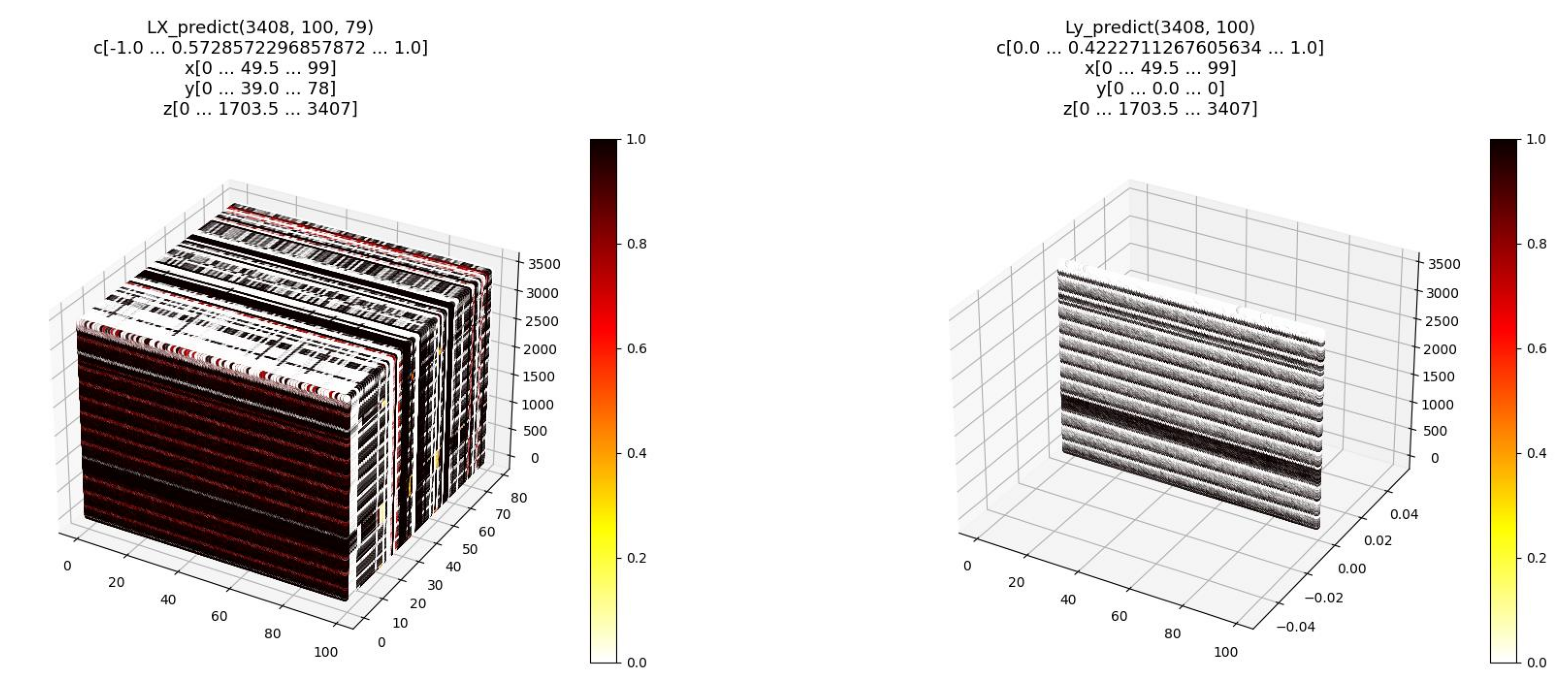

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-03-08 03:59:20.729077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-08 03:59:20.729823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-08 03:59:20.730558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-08 03:59:20.731278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0902            143811                 99           196680               210    340491        309       0.999093        0.000907


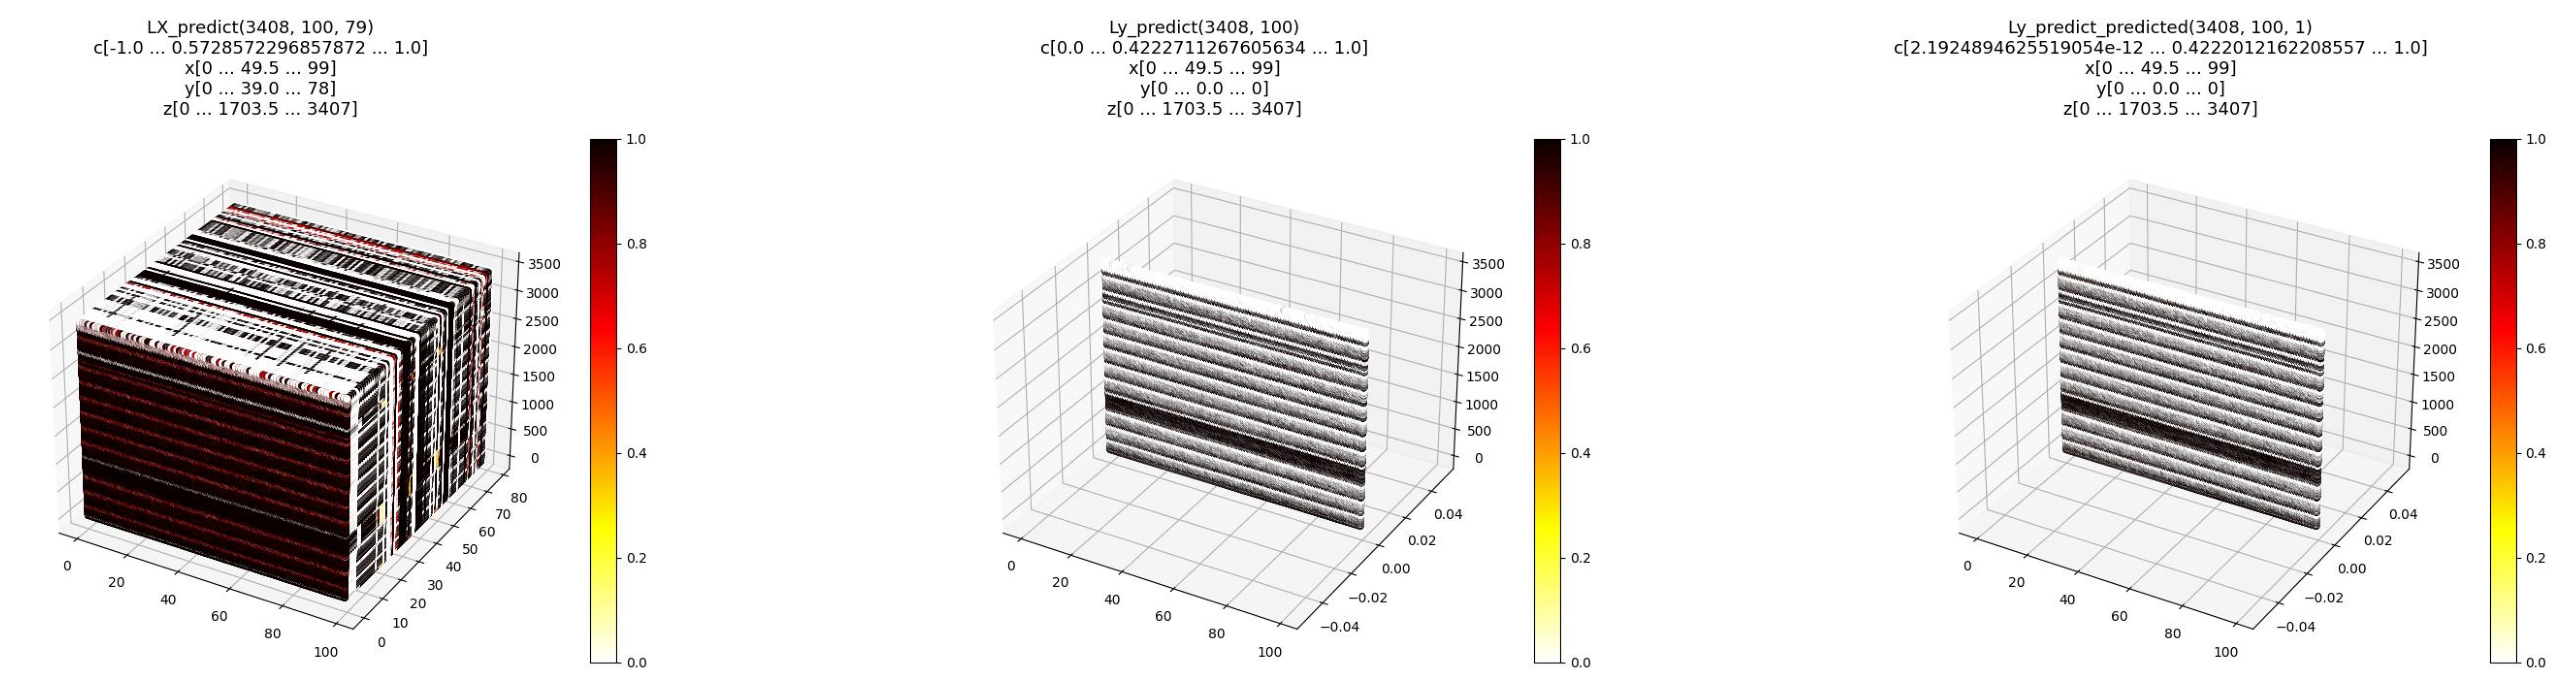

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0901            142188               1722           194995              1895    337183       3617       0.989387        0.010613


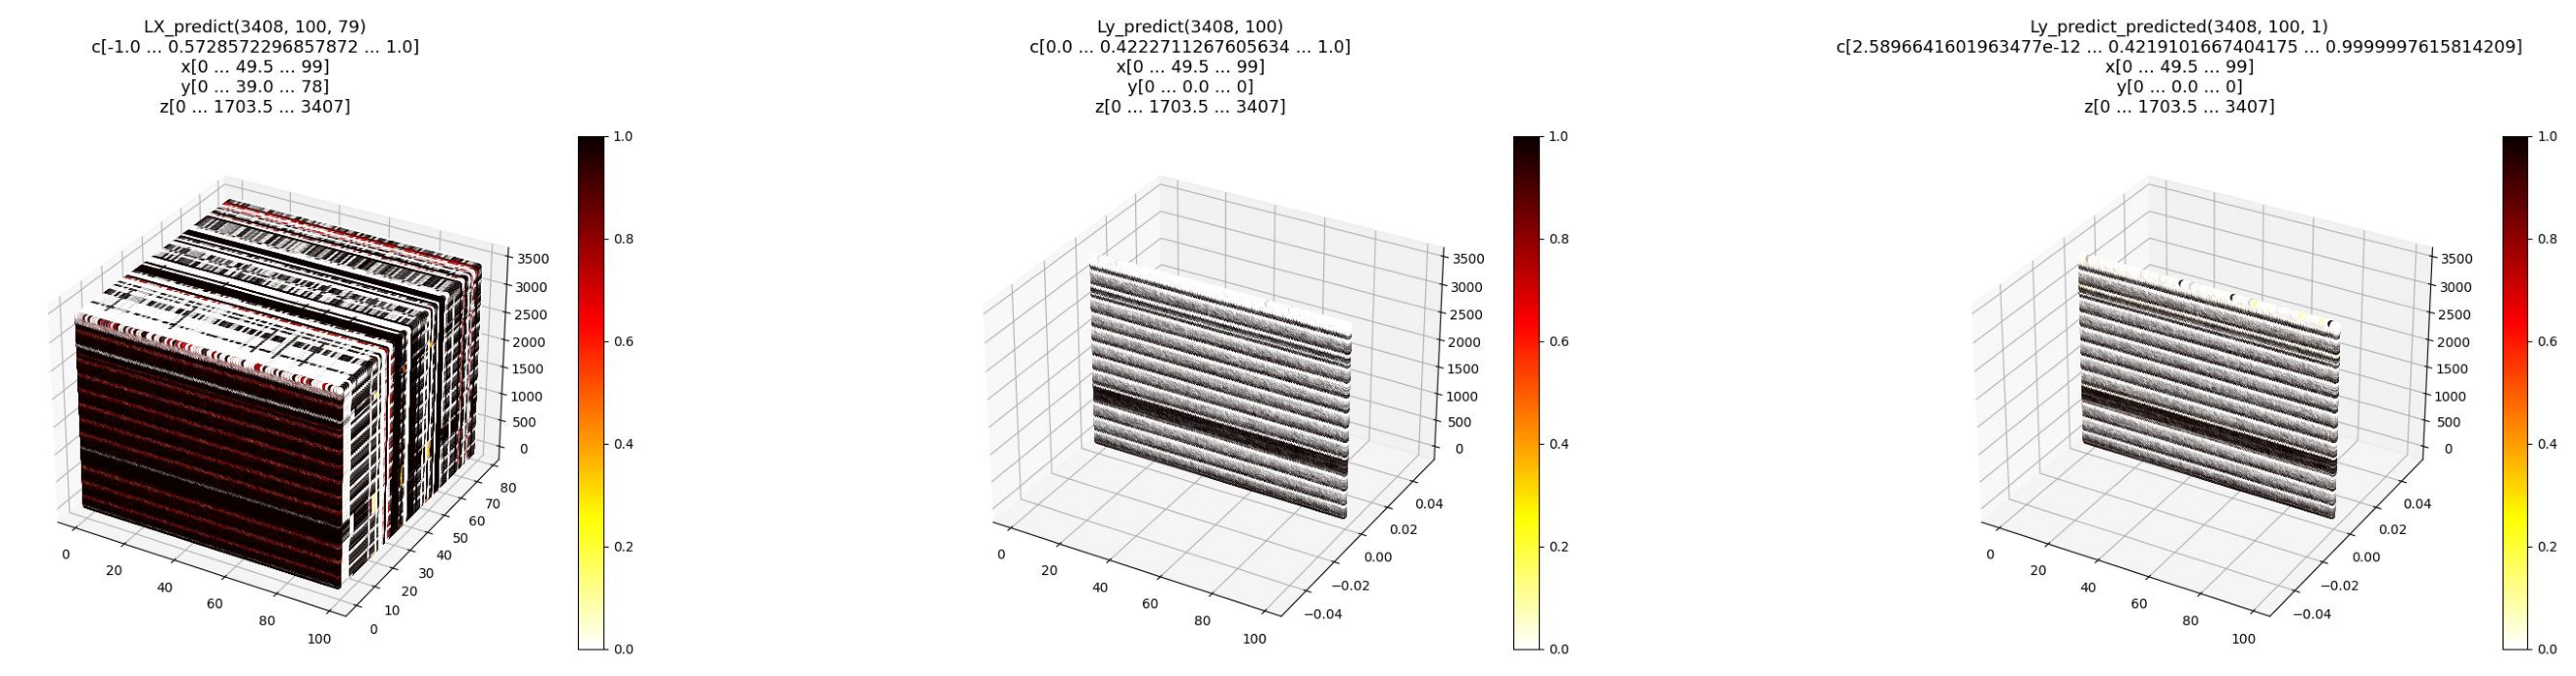

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0801             35116             108794           191141              5749    226257     114543         0.6639          0.3361


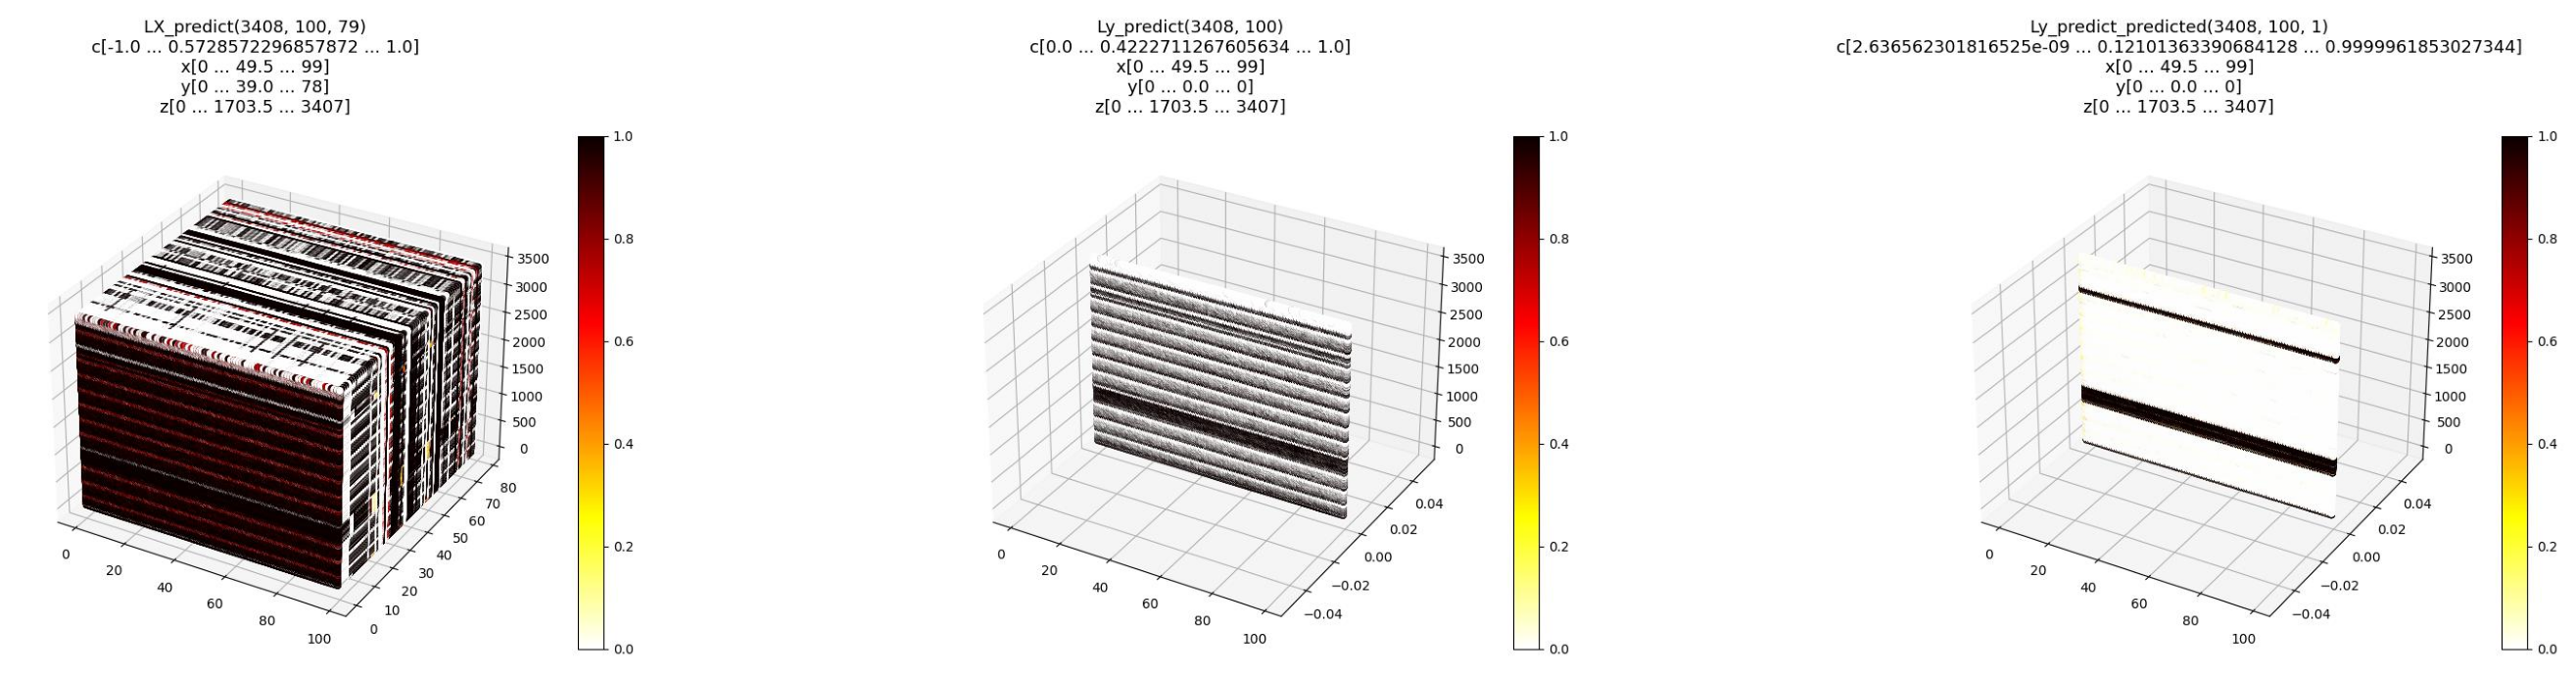

checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  \
0  2023W0902            143811                 99           196680   
1  2023W0901            142188               1722           194995   
2  2023W0801             35116             108794           191141   

   benign_incorrect  detected  incorrect  detected_rate  incorrect_rate  
0               210    340491        309       0.999093        0.000907  
1              1895    337183       3617       0.989387        0.010613  
2              5749    226257     114543       0.663900        0.336100

In [16]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df